In [1]:
import numpy as np
import pandas as pd
import virga.justdoit as jdi
import matplotlib.pyplot as plt
import astropy.units as u

In [2]:
def input_reader(input_file):
    input_data = []
    with open(input_file, "r") as f:
        lines = f.readlines()
        T_eff = float(lines[0])
        gravity = float(lines[1])
        num_layers = int(lines[2])
        for line in lines[4:]:
            parts = line.strip().split()
            input_data.append([float(x.replace("E", "e")) for x in parts])
        return T_eff, gravity, num_layers, np.array(input_data)

T_eff, gravity, num_layers, input_data = input_reader("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")
input_data = input_data[input_data[:,1].argsort()]

In [3]:
def layer(teff, grav, nzp1, nsub, t_edge, p_edge):
    """
    Calculate atmospheric profiles for Galileo probe sounding.
    Arguments:
        teff: effective temperature (K)
        grav: gravitational acceleration (cm/s^2)
        nzp1: number of layer edges
        nsub: number of sublayers
        t_edge: array of temperatures at layer edges (K), length nzp1
        p_edge: array of pressures at layer edges (bars), length nzp1
    Returns:
        nz: number of layers
        nzsub: total number of sublayers
        z: altitudes at layer midpoints (cm), length nzsub
        z_edge: altitudes at layer edges (cm), length nzsub+1
        p: pressures at layer midpoints (bars), length nzsub
        t: temperatures at layer midpoints (K), length nzsub
        chf: convective heat flux (erg/cm^2/s), float
        mixl: mixing length (cm), length nzsub
        kz: eddy diffusion coefficient (cm^2/s), length nzsub
    """
    r_atmos = 8.3143e7 / 2.2
    STEFBOLTZ = 5.67051e-5
    chf = STEFBOLTZ * teff ** 4

    
    p_edge = np.array(p_edge)
    t_edge = np.array(t_edge)
    nz = nzp1 - 1
    nzsub = nz*nsub

    z = np.zeros(nzsub)
    z_edge = np.zeros(nzsub+1)
    p = np.zeros(nzsub)
    t = np.zeros(nzsub)
    mixl = np.zeros(nzsub)
    kz = np.zeros(nzsub)

    z_edge[nzsub] = 0.0

    for iz in range(nz - 1, -1, -1):
        itop = iz
        ibot = iz + 1
        p_top, p_bot = p_edge[itop], p_edge[ibot]
        t_top, t_bot = t_edge[itop], t_edge[ibot]
        dp_layer = p_bot - p_top
        dlnp = np.log(p_bot/p_top)
        dtdlnp = ( t_top - t_bot ) / dlnp
        dp_sub = dp_layer/nsub
        scale_h = r_atmos * t_edge[ibot] / grav
        scalef_kz = 1/3
        p_sub_bot = p_bot
        z_edge_sub_bot = z_edge[ibot]
        t_sub_bot = t_bot

        for i in range(nsub-1, -1, -1):
            p_sub_top = p_sub_bot - dp_sub
            t_sub_top = t_sub_bot + np.log(p_sub_bot/p_sub_top)*dtdlnp
            dz_sub = scale_h * np.log(p_sub_bot/p_sub_top)
            p_sub = 0.5*(p_sub_bot+p_sub_top)
            t_sub = t_sub_bot + np.log(p_sub_bot/p_sub)*dtdlnp
            p[iz*nsub+i] = p_sub
            t[iz*nsub+i] = t_sub
            z_edge_sub_top = z_edge_sub_bot + dz_sub
            z_edge[iz*nsub+i] = z_edge_sub_top
            z[iz*nsub+i] = z_edge_sub_bot + scale_h*np.log(p_sub_bot/p_sub)
            lapse_ratio = (t_sub_bot - t_sub_top)/ np.log(p_sub_bot/p_sub_top) / (2/7 * t_sub)
            mixl[iz*nsub+i] = max(0.1, lapse_ratio) * scale_h
            rho_atmos = p_sub/(r_atmos*t_sub)
            c_p = (7/2)*r_atmos
            kz[iz*nsub+i] = scalef_kz * scale_h * (mixl[iz*nsub+i]/scale_h)**(4/3) * ((r_atmos*chf)/(rho_atmos*c_p))**(1/3)
            

            p_sub_bot = p_sub_top
            t_sub_bot = t_sub_top
            z_edge_sub_bot = z_edge_sub_top

    return nz, nzsub, z, z_edge, p, t, chf, mixl, kz

nz, nzsub, z, z_edge, p, t, chf, mixl, kz = layer(T_eff, gravity, num_layers, 1, input_data[:,0], input_data[:,1])


In [4]:
data = np.column_stack((t, p, z, mixl, kz, chf*np.ones_like(t)))
columns = ['temperature', 'pressure', 'altitude', 'mixing_length', 'kz', 'chf']
df = pd.DataFrame(data, columns=columns)

In [5]:
atmos = jdi.Atmosphere(['NH3'], fsed=1)
cmps2 = u.cm / u.s**2
atmos.gravity(gravity=gravity, gravity_unit=cmps2)
atmos.ptk(df=df, Teff=T_eff, convective_overshoot=1/3, latent_heat = True)

In [6]:
output = jdi.compute(atmo=atmos, directory='/home/sansar1/Codes/cloud_model/virga/virga/mieffs', og_solver=True, refine_TP=True, do_virtual=False)

In [7]:
# Read voyager_frain1_sig2.out
file = "/home/sansar1/Codes/cloud_model/output/voyager_frain1_sig2.out"
voyager = []
with open(file, "r") as f:
    lines = f.readlines()
    for line in lines[3:]:
        parts = line.strip().split()
        voyager.append([float(x.replace("E", "e")) for x in parts])
voyager = np.array(voyager)

print(voyager[:,4].shape)

(312,)


/tmp/ipykernel_10224/1363143758.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(qc), P, marker='o')
/tmp/ipykernel_10224/1363143758.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(voyager[:,4]), voyager[:,1]*(10**(-6)), marker='o')


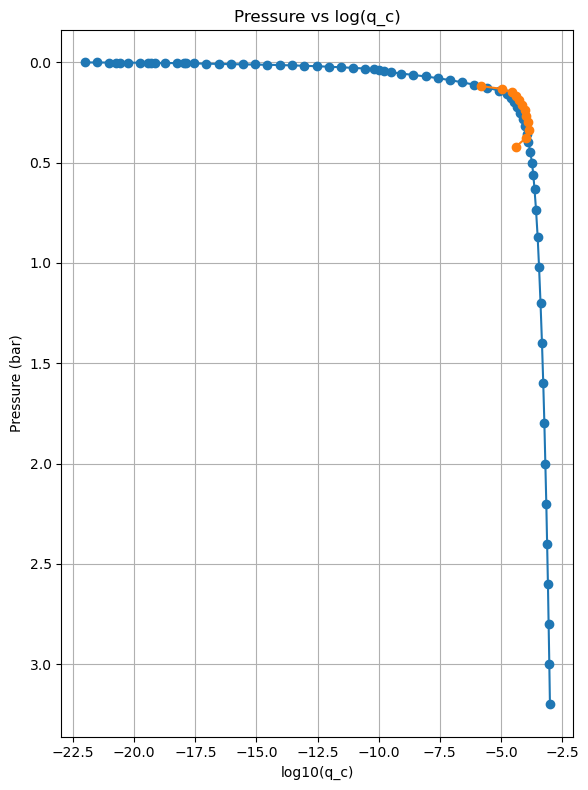

In [8]:
qc = output['condensate_mmr']
P = output['pressure']
plt.figure(figsize=(6, 8))
plt.plot(np.log10(qc), P, marker='o')
plt.plot(np.log10(voyager[:,4]), voyager[:,1]*(10**(-6)), marker='o')

plt.gca().invert_yaxis()  # invert pressure axis
plt.xlabel("log10(q_c)")
plt.ylabel("Pressure (bar)")  # assuming pressure in bar (confirm units)
plt.title("Pressure vs log(q_c)")
plt.grid(True)
plt.tight_layout()
plt.show()